<a href="https://colab.research.google.com/github/pkwon35/Smart_Factory_APS_System/blob/main/%EB%AA%A8%EB%8D%B8%EC%84%A0%EC%A0%95_%ED%95%99%EC%8A%B5%EA%B2%80%EC%A6%9Dipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('font', family='NanumBarunGothic')

In [ ]:
############################
######시멘트가동률지수######
############################


import pandas as pd
import requests

def korea_bank(col_name, code, item_code1='?', item_code2='?'):
  key = 'BBTRYO7WX8OVQ7IL8XZJ'
  data_start = '1'
  data_end= '1000'
  # code = '080Y111' 
  cycle = 'MM'
  search_start = '201601'
  search_end = '202104'
  # item_code1 = 'I32AL3'
  # item_code2 = 'I11B'
  url = f'http://ecos.bok.or.kr/api/StatisticSearch/{key}/json/kr/{data_start}/{data_end}/{code}/{cycle}/{search_start}/{search_end}/{item_code1}/{item_code2}'
  res = requests.get(url)
  data = res.json()
  data = data['StatisticSearch']['row']
  df = pd.DataFrame(data).set_index('TIME')
  df = df[['DATA_VALUE']]
  df.rename(columns={df.columns[0]:col_name},inplace=True)
  return df

가동률지수 = korea_bank('가동률지수','080Y111','I32AL3','I11B')

In [4]:
org_df = pd.read_csv('/content/drive/MyDrive/5조_스마트팩토리/조현정/data(2016)_2.csv',index_col=0)
temp_data = pd.read_pickle('/content/drive/MyDrive/5조_스마트팩토리/진유훈/temp18_21.pkl')
org_df

,거래처코드,제품코드,납기일자,prod_name,region,sold_quant
0,2002700,PEMA033101400,2016-01-07,PEMA-580FX,금산,7950.0
1,2006900,PEMA033101400,2016-01-23,PEMA-580FX,금산,10710.0
2,2001300,PEMA033101400,2016-01-30,PEMA-580FX,금산,10600.0
3,2004400,PEMA023098200,2016-01-03,PEMA-580FX,부산,10600.0
4,2006600,PEMA023098200,2016-01-09,PEMA-580FX,부산,10600.0
...,...,...,...,...,...,...
54838,2006200,PEMA013122800,2021-04-24,CSA5000,안동,10000.0
54839,2007000,TSN4012011123,2021-04-24,PEMA-SN400,진접,10000.0
54840,2007400,PEMA043103800,2021-04-24,PEMA-SR2000,인천,10000.0
54841,2007500,PEMA023122400,2021-04-24,PEMA-SR2000,부산,8000.0


In [5]:
org_df['납기일자'] = pd.to_datetime(org_df['납기일자'])
df = org_df.copy()
len(df['prod_name'].unique())
cdf = df[(df['납기일자'] > '2017')]
cdf = cdf.rename(columns= {'납기일자':'일자'})

# 가장 많이 팔린 순으로 상품 정렬 후 리스트 만들기
product_list = cdf['prod_name'].value_counts().index
product_list[0]

# product_list[0] (PEMA-HR1000) 인 제품 거래만 가져오기 one_product

cdf = cdf[cdf['prod_name'] == product_list[0]][['일자','sold_quant']]
opdf = cdf.groupby('일자')[['sold_quant']].sum()
opdf


## 온도 습도 merge
mdf = pd.merge(opdf, temp_data, on='일자',how='outer')
mdf.dropna(axis=0,inplace=True)
mdf.set_index('일자',inplace=True)
mdf = mdf[['sold_quant','기온','습도']]
mdf

,sold_quant,기온,습도
일자,,,
2017-01-02,30680.0,4.700000,83.000000
2017-01-04,74610.0,4.200000,70.500000
2017-01-05,102310.0,4.300000,71.300003
2017-01-06,74990.0,6.700000,66.000000
2017-01-07,63090.0,4.300000,74.800003
...,...,...,...
2021-04-19,50000.0,13.500000,58.299999
2021-04-21,122000.0,19.600000,43.500000
2021-04-22,124000.0,21.799999,35.400002


In [6]:
# 시각화 및 RMSE, R2_SCORE

def actual_pred_plot(preds):
    global train_size
    actual_pred = pd.DataFrame(columns = ['sold_quant', 'prediction'])
    actual_pred['sold_quant'] = mdf.loc[train_size:,'sold_quant'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    from sklearn.metrics import r2_score
    # from keras.metrics import r2_score
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['sold_quant']),np.array(actual_pred['prediction']))
    r2 = r2_score(actual_pred['prediction'], actual_pred['sold_quant'])

    print('RMSE :',np.sqrt(m.result().numpy()))
    print('R2 Score: {:.4f}'.format(r2))
    return (m.result().numpy(), actual_pred.plot() )
    
# actual_pred_plot(rnn_predictions)

(1064, 5, 1)
(281, 1)
######################################################################################################################################################
Simple RNN
RMSE : 17632.244
R2 Score: 0.6879


(310896060.0, <matplotlib.axes._subplots.AxesSubplot at 0x7f99097f8f10>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)


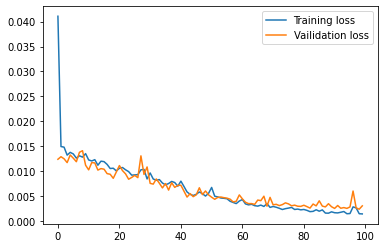

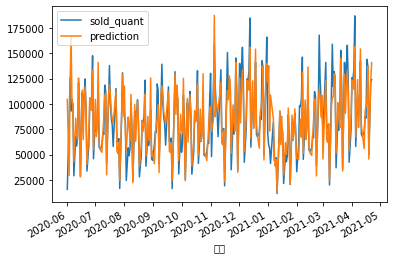

In [11]:
train_size = '2020-06'
BATCH_SIZE = 16
time_steps = 7
unit = 128

def ts_train_test_normalize(all_data,time_steps,for_periods):
    global train_size
    # train_size = int(len(all_data) * 0.8)

    # train test split 해주기
    ts_train = all_data[:train_size].iloc[:,0:3].values
    ts_test  = all_data[train_size:].iloc[:,0:3].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # 데이터정규화
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    print(X_train.shape)
    inputs = pd.concat((all_data["sold_quant"][:train_size], all_data["sold_quant"][train_size:]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    print(inputs.shape)
    inputs  = sc.fit_transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc



def simple_rnn_model(X_train, y_train, X_test, sc, unit):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    from tensorflow.keras.losses import Huber
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(unit, return_sequences=True))
    my_rnn_model.add(SimpleRNN(unit, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(unit))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='adam', loss=Huber(), metrics=['mse'])

    # fit the RNN model
    history = my_rnn_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=BATCH_SIZE, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label = 'Vailidation loss')
    plt.legend()
    return my_rnn_model, rnn_predictions

X_train, y_train, X_test, sc = ts_train_test_normalize(mdf,5,2)
my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc, unit)
rnn_predictions_2[1:10]
print('#'*150)
print('Simple RNN')
actual_pred_plot(rnn_predictions_2)

######################################################################################################################################################
LSTM
######################################################################################################################################################
RMSE : 14648.782
R2 Score: 0.8085


(214586820.0, <matplotlib.axes._subplots.AxesSubplot at 0x7f98c5d0a210>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)


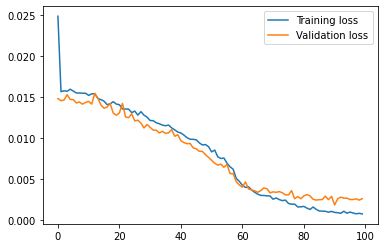

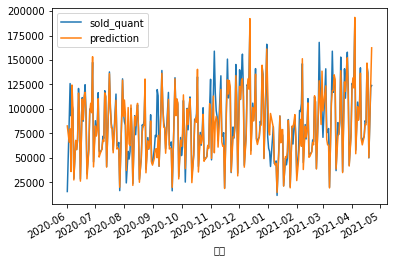

In [17]:
def LSTM_model(X_train, y_train, X_test, sc , unit):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.losses import Huber
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=unit, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='adam',loss=Huber(), metrics='mse')
    # Fitting to the training set
    history = my_LSTM_model.fit(X_train,y_train, validation_split=0.2,epochs=100,batch_size=BATCH_SIZE, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.legend()

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc , unit)
LSTM_prediction[1:10]
print('#'*150)
print('LSTM')
print('#'*150)
actual_pred_plot(LSTM_prediction)

RMSE : 14923.609
R2 Score: 0.8017


(222714110.0, <matplotlib.axes._subplots.AxesSubplot at 0x7f99057c8610>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)


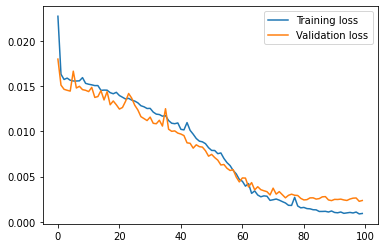

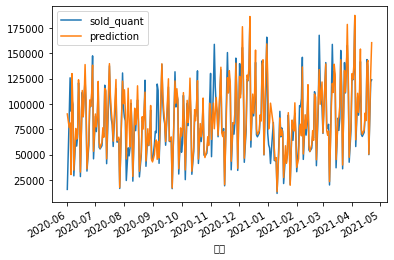

In [18]:
def LSTM_model_regularization(X_train, y_train, X_test, sc, unit):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.losses import Huber
    # from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=unit, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='adam',loss=Huber(), metrics=['mse'])
    # Fitting to the training set
    history = my_LSTM_model.fit(X_train,y_train, validation_split=0.2,epochs=100,batch_size=BATCH_SIZE, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.legend()

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc, unit)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

######################################################################################################################################################
GRU
######################################################################################################################################################
RMSE : 12647.206
R2 Score: 0.8641


(159951820.0, <matplotlib.axes._subplots.AxesSubplot at 0x7f98fb755450>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)


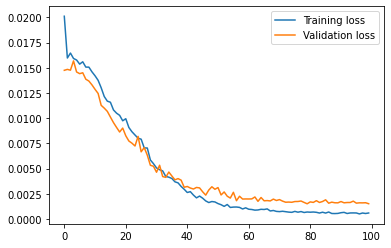

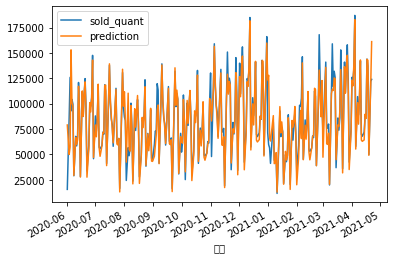

In [19]:
def GRU_model(X_train, y_train, X_test, sc, unit):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.losses import Huber
    # from keras.optimizers import SGD
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=16, activation='tanh'))
    my_GRU_model.add(Dense(units=2))

    # Compiling the RNN
    my_GRU_model.compile(optimizer='adam',loss=Huber(), metrics=['mse'])
    # Fitting to the training set
    history = my_GRU_model.fit(X_train,y_train, validation_split=0.2,epochs=100,batch_size=BATCH_SIZE, verbose=0)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.legend()

    return my_GRU_model, GRU_prediction

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc, unit)
GRU_prediction[1:10]
print('#'*150)
print('GRU')
print('#'*150)
actual_pred_plot(GRU_prediction)

######################################################################################################################################################
GRU reg
######################################################################################################################################################
RMSE : 24435.736
R2 Score: 0.0989


(597105200.0, <matplotlib.axes._subplots.AxesSubplot at 0x7f98c5f127d0>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)


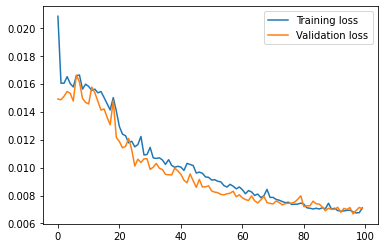

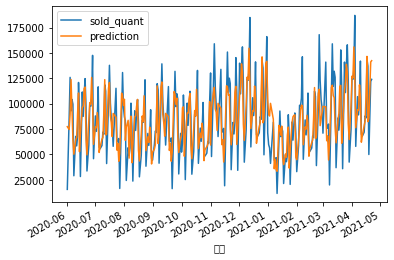

In [20]:
def GRU_model_regularization(X_train, y_train, X_test, sc , unit):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    # from keras.optimizers import SGD
    from keras.layers import Dropout
    from tensorflow.keras.losses import Huber
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer
    my_GRU_model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    
    # Third GRU layer
    my_GRU_model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
    # my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer
    my_GRU_model.add(GRU(units=unit, activation='tanh'))
    # my_GRU_model.add(Dropout(0.2))
    # The output layer
    my_GRU_model.add(Dense(units=1))
    # Compiling the RNN
    my_GRU_model.compile(optimizer='adam',loss=Huber(), metrics=['mse'])
    # Fitting to the training set
    history = my_GRU_model.fit(X_train,y_train, validation_split=0.2,epochs=100,batch_size=BATCH_SIZE, verbose=0)

    GRU_predictions = my_GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.legend()

    
    return my_GRU_model, GRU_predictions

my_GRU_model, GRU_predictions = GRU_model_regularization(X_train, y_train, X_test, sc , unit)
print('#'*150)
print('GRU reg')
print('#'*150)
actual_pred_plot(GRU_predictions)

In [ ]:
my_GRU_model.summary()